<a href="https://colab.research.google.com/github/peppermintbird/nabs-prototype/blob/main/snn_proto_exo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> *This notebook is a compendium of snnTorch's tutorials, Kaggle's competition datasets, and my own coding and experiments. Credits and ownership are duly referenced.*

### Data setup and preprocessing

First of all, ensure you have the needed requirements to use snnTorch. [By following PyPi's latest version of snnTorch](https://pypi.org/project/snntorch/), you should find a quick start in how to setup the package.

* Install or collect the following packages and libraries; ignore those you already have installed. Optionally, add the `--quiet` flag to avoid cumbersome output messages.

In [ ]:
!pip install snntorch
!pip install torch
!pip install imblearn
!pip install torchvision
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install plotly.express



* Now import those packages.

In [7]:
# importing snnTorch
import snntorch as snn
from snntorch import surrogate

# setting pyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# SMOTE (oversampling to balance the dataset)
from imblearn.over_sampling import SMOTE
from collections import Counter

# plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# metric (AUC, ROC, sensitivity & specificity)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


* Download the dataset from [Kaggle](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data/data) and then export it to Google Drive if you're using Google Colab. To ensure your files are accessible on Google Colab, mount them at `/content/drive` to connect your Drive to Google Colab.

  * For this small project we will use tested datasets:
    1. `exoTest.csv`
    2. `exoTrain.csv`

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd '/content/drive/MyDrive/SNN'



/content/drive/MyDrive/SNN


Just to be _sure_, let's see if the files can indeed be found.

In [10]:
!ls exoTest.csv exoTrain.csv

exoTest.csv  exoTrain.csv


- The next step is optional, but I think it's good if you didn't get to understand the data you're handling.

> **Reminder:**

Var 1 = Contain the label attribute stating:
      
  - 1 = no exoplanet

  - 2 = exoplanet

 If 1 and 2 are somewhat inconvenient, don't worry, we will change these label values into more intuitive ones, like 0 and 1.


Var 2 - 3098 = Contain the flux values measured at different points in time.

* Read your datasets by stating:   

In [11]:
exoTest = pd.read_csv('/content/drive/MyDrive/SNN/exoTest.csv')
exoTrain = pd.read_csv('/content/drive/MyDrive/SNN/exoTrain.csv')

exoTest.tail(10) # you can input here the number of rows you wish to peruse

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
560,1,5.66,7.83,-4.39,-0.62,-5.23,0.34,-13.64,-11.26,-9.96,...,15.15,24.89,23.41,26.33,44.37,46.15,37.28,45.60,41.66,39.35
561,1,4.36,2.22,5.61,-1.44,-0.05,-0.22,1.28,-13.20,-5.83,...,2.94,-2.90,2.12,11.26,12.81,6.03,-6.13,-10.46,-5.36,-14.23
562,1,-79.95,-79.13,-81.07,-72.25,-79.71,-70.60,-90.33,-88.66,-68.15,...,5.40,19.51,-0.15,1.67,3.20,7.25,-8.25,-7.91,4.45,6.58
563,1,-63.42,-59.78,-64.16,-61.07,-41.74,-58.99,-35.94,-43.15,-24.87,...,-13.98,0.62,-5.53,-14.26,-23.69,-37.84,-2.37,6.62,12.02,2.33
564,1,144.47,20.09,147.47,109.18,100.87,24.87,115.03,106.37,48.87,...,-57.53,-41.94,-165.94,-265.13,-263.35,-376.53,-176.22,-152.07,-216.60,-202.97
565,1,374.46,326.06,319.87,338.23,251.54,209.84,186.35,167.46,135.45,...,-123.55,-166.90,-222.44,-209.71,-180.16,-166.83,-235.66,-213.63,-205.99,-194.07
566,1,-0.36,4.96,6.25,4.20,8.26,-9.53,-10.10,-4.54,-11.55,...,-12.40,-5.99,-17.94,-11.96,-12.11,-13.68,-3.59,-5.32,-10.98,-11.24
567,1,-54.01,-44.13,-41.23,-42.82,-39.47,-24.88,-31.14,-24.71,-13.12,...,-0.73,-1.64,1.58,-4.82,-11.93,-17.14,-4.25,5.47,14.46,18.70
568,1,91.36,85.60,48.81,48.69,70.05,22.30,11.63,37.86,28.27,...,2.44,11.53,-16.42,-17.86,21.10,-10.25,-37.06,-8.43,-6.48,17.60
569,1,3071.19,2782.53,2608.69,2325.47,2089.37,1769.56,1421.09,1142.09,902.31,...,695.41,865.97,882.41,1203.06,1293.03,1354.41,-192.81,-277.22,-69.63,121.56


In [12]:
exoTrain.tail(10)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
5077,1,125.57,78.69,98.29,91.16,78.42,45.82,61.69,22.73,39.09,...,32.35,63.23,57.98,90.43,115.12,210.09,3.80,16.33,27.35,21.30
5078,1,7.45,10.02,6.87,-2.82,-1.56,-4.30,-7.01,-6.97,-2.54,...,-5.25,-8.56,0.53,-4.29,-6.60,8.75,-10.69,-9.54,-2.48,-8.69
5079,1,475.61,395.50,423.61,376.36,338.94,321.26,326.34,342.84,251.23,...,543.25,453.87,344.35,266.16,242.18,163.02,86.29,13.06,161.22,213.60
5080,1,-46.63,-55.39,-64.88,-88.75,-75.40,-64.06,-66.37,-41.95,-68.07,...,29.64,6.90,32.94,56.63,28.71,28.82,-20.12,-14.41,-43.35,-30.04
5081,1,299.41,302.77,278.68,263.48,236.89,186.93,145.45,151.20,123.38,...,-126.36,-133.82,-134.02,-98.76,-106.60,-74.95,-46.29,-3.08,-28.43,-48.68
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55
5086,1,323.28,306.36,293.16,287.67,249.89,218.30,188.86,178.93,118.93,...,71.19,0.97,55.20,-1.63,-5.50,-25.33,-41.31,-16.72,-14.09,27.82


In [13]:
print(exoTest['LABEL'].value_counts())
print(exoTrain['LABEL'].value_counts())

1    565
2      5
Name: LABEL, dtype: int64
1    5050
2      37
Name: LABEL, dtype: int64


**Key takeways:**

- You should notice the large imbalance in those datasets. Because of that, we will apply SMOTE to regularize the data later on in this notebook.

- From the print function we could see that, in both datasets, the number of positive samples is overwhelmingly smaller than the negative ones. Soon we will further analyze the disparity between samples in the training dataset, which will be our main focus.




Hooray! Now that the setup is done, let's customize the dataset to our needs. We'll also augment the data to adress the imbalance issue.



---

### Data customization and augmentation

#### **Customization**

- Continuing on the data preprocessing, we will use PyTorch to custom the data.

In [14]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        with open(csv_file,"r") as f:
            self.data = pd.read_csv(f) # read the files
        self.labels = self.data.iloc[:,0].values - 1 # set the first line of the input data as the label (Originally 1 or 2, but we will transform them into 0 or 1 by decreasing 1)
        self.features = self.data.iloc[:, 1:].values # set the rest of the input data as the feature (FLUX over time)
        self.transform = transform # transformation (which is None) that will be applied to samples.


▶ Following [PyTorch's official tutorial for deep learning frameworks](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html), we have the CSV file opened and its contents read using `pd.read_csv()` from the Pandas library.

▶ The data is stored in the `self.data` attribute. The labels are extracted from the first column `(iloc[:,0])` of the data using `.values`.

▶ The labels are then transformed by subtracting 1, converting them from 1 or 2 to 0 or 1 respectively. These transformed labels are stored in the `self.labels` attribute.

- To further analyze this problem, we can look at the dataset's imbalance by creating a chart.

In [16]:
 def __len__(self): # function that gives back the size of the dataset (how many samples)
        return len(self.labels)

 def __getitem__(self, idx): # retrieves a data sample from the dataset
        label = self.labels[idx] # fetch label of sample
        feature = self.features[idx] # fetch features of sample

        if self.transform: # if there is a specified transformation, transform the data
            feature = self.transform(feature)

        sample = {'feature': feature, 'label': label}
        return sample

train_dataset = CustomDataset('./exoTrain.csv') # grab the training data
test_dataset = CustomDataset('./exoTest.csv') # grab the test data




To check if the transformation was successful, you can call a print function as we did before, but this time with Pandas by adding `pd.Series`.

In [17]:
print("LABEL:", pd.Series(test_dataset.labels).value_counts())
print("LABEL:", pd.Series(train_dataset.labels).value_counts())

LABEL: 0    565
1      5
dtype: int64
LABEL: 0    5050
1      37
dtype: int64


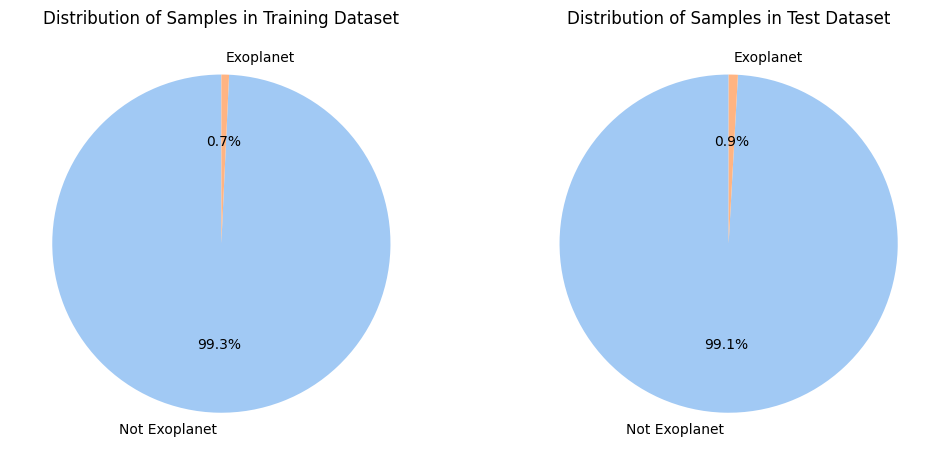

In [18]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['Not Exoplanet','Exoplanet']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, dataset in enumerate([train_dataset, test_dataset]):
    label_counts = np.bincount(dataset.labels)
    axes[i].pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[i].set_title('Distribution of Samples in ' + ['Training', 'Test'][i] + ' Dataset')

plt.show()

As we can see, the training dataset, although slightly, has more imbalance than the test dataset.

#### **Augmentation**

According to [Chawla, Bowyer, et al. (2002)](https://www.jair.org/index.php/jair/article/view/10302), Synthetic Minority Over-Sampling Technique (SMOTE) combines under-sampling of the majority class -- in our case, the negative samples of exoplanet candidates -- with a unique form of over-sampling the minority class to address class imbalance.

So, in essence, SMOTE balances the samples by creating synthetic data points from the minority class.

In [19]:


# initialize smote with default sampling strategy
smote = SMOTE()


# update the labels and features to the resampled data
train_dataset.features, train_dataset.labels = smote.fit_resample(train_dataset.features, train_dataset.labels)


print("Class distribution in the testing dataset after SMOTE:", pd.Series(test_dataset.labels).value_counts())
print("Class distribution in the training dataset after SMOTE:", pd.Series(train_dataset.labels).value_counts())

Class distribution in the testing dataset after SMOTE: 0    565
1      5
dtype: int64
Class distribution in the training dataset after SMOTE: 1    5050
0    5050
dtype: int64


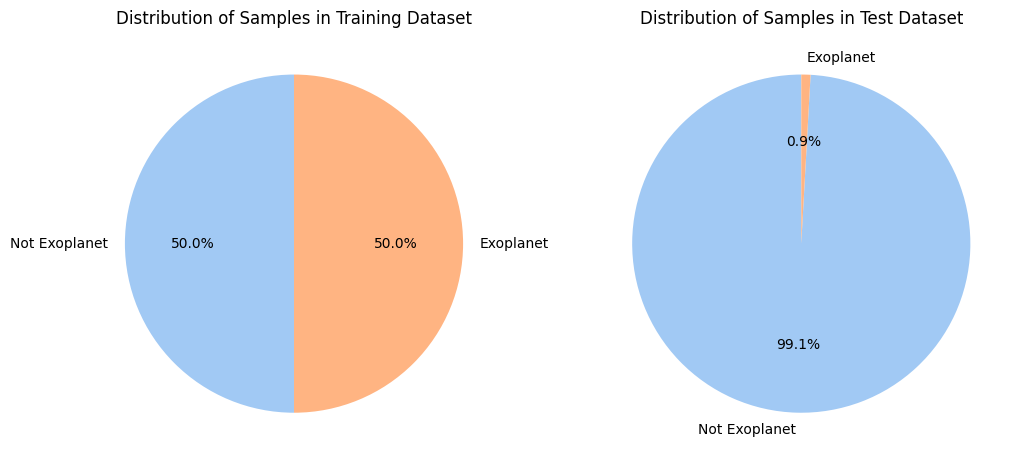

In [20]:
label_counts = np.bincount(train_dataset.labels)
label_names = ['Not Exoplanet','Exoplanet']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, dataset in enumerate([train_dataset, test_dataset]):
    label_counts = np.bincount(dataset.labels)
    axes[i].pie(label_counts, labels=label_names, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[i].set_title('Distribution of Samples in ' + ['Training', 'Test'][i] + ' Dataset')

plt.show()



---







### DataLoader

Creating a DataLoader allows us, among other things, to load data in batches, making it easier to process large datasets without loading everything into memory at once.


It also can shuffle the data, which is important for training models to prevent the model -- wait for it -- from learning the order of the data!

In [ ]:
# number of samples in each batch during training
batch_size = 64

spike_grad = surrogate.fast_sigmoid(slope=25)

# initialize a beta value of 0.5
beta = 0.5

# create a dataloader for the trainset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# create a dataloader for the testset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [25]:
print(train_dataset.data.head(1))

   LABEL  FLUX.1  FLUX.2  FLUX.3  FLUX.4  FLUX.5  FLUX.6  FLUX.7  FLUX.8  \
0      2   93.85   83.81    20.1  -26.98  -39.56 -124.71 -135.18  -96.27   

   FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  FLUX.3192  \
0  -79.89  ...     -78.07    -102.15    -102.15      25.13      48.57   

   FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      92.54      39.32      61.42       5.08     -39.54  

[1 rows x 3198 columns]


In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Star #0 (Exoplanet)", "Star #1 (Exoplanet)",
                                                   "Star #3000 (No-Exoplanet)", "Star #3001 (No-Exoplanet)"))
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(0)['feature']),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(1)['feature']),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3000)['feature']),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_dataset.__getitem__(3001)['feature']),
    row=2, col=2
)
for i in range(1, 5):
    fig.update_xaxes(title_text="Time", row=(i-1)//2 + 1, col=(i-1)%2 + 1)
    fig.update_yaxes(title_text="Flux", row=(i-1)//2 + 1, col=(i-1)%2 + 1)

fig.update_layout(height=600, width=800, title_text="Exoplanets Flux vs No-Exoplanet Flux",showlegend=False)
fig.show()

---


### Model network